In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as un
from astropy.coordinates import SkyCoord
from astropy.units import Quantity
from astropy.stats import median_absolute_deviation as mad
from astropy.cosmology import Planck18

In [2]:
def get_lims(wcs: WCS = None, radius: Quantity=None, center_coord: SkyCoord=None):
    if isinstance(radius, Quantity):
        if radius.isscalar:
            radius_x = radius_y = radius
        else:
            radius_x = radius[0]
            radius_y = radius[1]

    else:
        if isinstance(radius, list):
            radius_x = radius[0] * un.deg
            radius_y = radius[1] * un.deg
        else:
            radius_x = radius_y = radius * un.deg

    left_corner = SkyCoord(ra=center_coord.ra - radius_x, dec=center_coord.dec - radius_y)
    right_corner = SkyCoord(ra=center_coord.ra + radius_x, dec=center_coord.dec + radius_y)
    left, up = left_corner.to_pixel(wcs, origin=0)
    right, down = right_corner.to_pixel(wcs, origin=0)
    xlim = [int(right), int(left)]
    ylim = [int(up), int(down)]
    return xlim, ylim

In [3]:
rm_hdu=fits.open("/home/miguel/Documents/datasets/A1314_JVLA/mfs/rm_images/max_faraday_depth.fits")[0]
p_hdu= fits.open("/home/miguel/Documents/datasets/A1314_JVLA/mfs/rm_images/max_rotated_intensity.fits")[0]
sigma_qu_hdu=fits.open("/home/miguel/Documents/datasets/A1314_JVLA/mfs/rm_images/sigma_qu_faraday.fits")[0]
sigma_phi_hdu=fits.open("/home/miguel/Documents/datasets/A1314_JVLA/mfs/rm_images/sigma_phi_peak.fits")[0]

In [4]:
cluster_center_coord = SkyCoord(ra=173.714 * un.deg, dec=49.091 * un.deg, frame="fk5")

In [5]:
#center_coord = SkyCoord(ra=173.705 * un.deg,dec=49.077 *un.deg, frame="fk5") # Center Source
#center_coord = SkyCoord(ra=173.479 * un.deg,dec=49.064 *un.deg, frame="fk5") # C-W Source
#center_coord = SkyCoord(ra=173.654 * un.deg,dec=48.978 *un.deg, frame="fk5") # C-S Extended
#center_coord = SkyCoord(ra=173.453 * un.deg,dec=48.985 *un.deg, frame="fk5") # S-W Source
#center_coord = SkyCoord(ra=173.803 * un.deg,dec=48.966 *un.deg, frame="fk5") # S-E Source

In [6]:
# Centers based on core centers
#center_coord = SkyCoord(ra=173.705 * un.deg,dec=49.077 *un.deg, frame="fk5") # Center Source
#center_coord = SkyCoord(ra=173.496 * un.deg,dec=49.062 *un.deg, frame="fk5") # C-W Source
#center_coord = SkyCoord(ra=173.693 * un.deg,dec=48.956 *un.deg, frame="fk5") # C-S Extended
#center_coord = SkyCoord(ra=173.453 * un.deg,dec=48.985 *un.deg, frame="fk5") # S-W Source
#center_coord = SkyCoord(ra=173.803 * un.deg,dec=48.966 *un.deg, frame="fk5") # S-E Source
#center_coord = SkyCoord(ra=173.521 * un.deg,dec=49.106 *un.deg, frame="fk5") # 5
#center_coord = SkyCoord(ra=173.762 * un.deg,dec=49.193 *un.deg, frame="fk5") # 12
center_coord = SkyCoord(ra=173.943 * un.deg,dec=48.921 *un.deg, frame="fk5") # 15

In [7]:
dist_to_center = center_coord.separation(cluster_center_coord)

In [8]:
dist_to_center.arcsec * un.arcsec

<Quantity 816.69849618 arcsec>

In [9]:
redshift_z = 0.034 # X-Ray Center
#redshift_z = 0.033 # Center Source
#redshift_z = 0.032 # C-W Source
#redshift_z = 0.032 # C-S Extended

In [10]:
dist = Planck18.comoving_distance(redshift_z)
scale = Planck18.arcsec_per_kpc_comoving(redshift_z)

In [11]:
dist_kpc = dist_to_center.arcsecond * un.arcsec / scale

In [12]:
dist_kpc

<Quantity 591.72751038 kpc>

In [13]:
wcs = WCS(rm_hdu.header, naxis=2)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [14]:
rm = rm_hdu.data
p = p_hdu.data
sigma_qu = sigma_qu_hdu.data
sigma_phi = sigma_phi_hdu.data

In [15]:
rm = np.where(p>6*sigma_qu, rm, np.nan)
sigma_phi = np.where(p>6*sigma_qu, sigma_phi, np.nan)

In [16]:
x_lim, y_lim = get_lims(wcs, radius=0.02*un.deg, center_coord=center_coord)

In [17]:
rm = rm[y_lim[0]:y_lim[1], x_lim[0]:x_lim[1]]
sigma_phi = sigma_phi[y_lim[0]:y_lim[1], x_lim[0]:x_lim[1]]

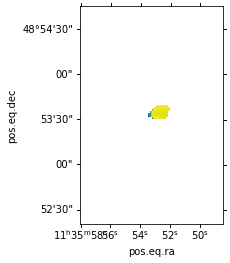

In [18]:
ax = plt.subplot(projection=wcs)
ax.imshow(rm)
#ax.set_xlim(x_lim[1], x_lim[0])
#ax.set_ylim(y_lim[1], y_lim[0])
plt.show()

In [19]:
avg_rm = np.nanmean(rm)
med_rm = np.nanmedian(rm)
mad_rm = np.nanmedian(np.abs(rm-np.nanmedian(rm)))
sigma_rm_obs = np.nanstd(rm)
med_sigma_phi = np.nanmedian(sigma_phi)
sigma_rm = np.sqrt(sigma_rm_obs**2 - med_sigma_phi**2)

In [20]:
npixels = np.count_nonzero(~np.isnan(rm))

In [21]:
dx = rm_hdu.header["CDELT1"] * un.deg
dy = rm_hdu.header["CDELT2"] * un.deg

In [22]:
bmaj = 12.36950969696045 * un.arcsec 
bmin = 11.706433296203613 * un.arcsec
area_pixels = np.pi * bmaj.to(un.deg) * bmin.to(un.deg) / (4.*np.log(2)) /(-dx*dy)
nbeams = npixels / area_pixels

In [23]:
mean_error = sigma_rm_obs/np.sqrt(nbeams)
sigma_error = sigma_rm/np.sqrt(nbeams)

In [24]:
print("<RM> : {0:.3f}".format(avg_rm))
print("sigma(RM): {0:.3f}".format(sigma_rm))
print("med(RM): {0:.3f}".format(med_rm))
print("MAD(RM): {0:.3f}".format(mad_rm))
print("med(sigma_phi): {0:.3f}".format(med_sigma_phi))
print("nbeams: {0:.3f}".format(nbeams))
print("sigma(RM)_obs: {0: .3f}".format(sigma_rm_obs))
print("mean error: {0: .3f}".format(mean_error))
print("sigma error: {0: .3f}".format(sigma_error))

<RM> : 0.589
sigma(RM): 67.149
med(RM): 19.685
MAD(RM): 6.562
med(sigma_phi): 2.753
nbeams: 0.803
sigma(RM)_obs:  67.206
mean error:  74.979
sigma error:  74.916
